In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders
! pip install optuna

In [ ]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative
import random
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb
import xgboost as xgb

from optuna.integration import _lightgbm_tuner as lgb_tuner
import optuna

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [ ]:
class CFG:
  exp = "exp18"
  seed = 71
  fold = 10

CONFIG = CFG()

In [ ]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [ ]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

# 処理済みデータ読み込み

In [ ]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [ ]:
df_train_org = df_train.copy()

In [ ]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-21 21:38:07.200,2021-09-21 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-21 21:38:15.600,2021-09-21 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-21 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:21.200,NaT,1.0,14,14


In [ ]:
df_train_0=df_train[df_train.event_type !=3].reset_index(drop=True)
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [ ]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [ ]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_train.columns=["customer_id","time_duration_frame","in_time"]
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test.columns=["customer_id","time_duration_frame","in_time"]

# shopper area time
df_sub=df_train[df_train.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_train = df_sub[~df_sub.num_touch.isnull()]
df_area_train =df_area_train.drop_duplicates()
df_area_train = df_area_train[["customer_id","area_id","time_duration"]]
df_area_train.columns=["customer_id","area_id","time_duration_area"]

df_sub=df_test[df_test.event_type !=1].sort_values(["customer_id","event_type"]).reset_index(drop=True)
df_sub["time_duration"] =df_sub["time_duration"].replace(0,None) 
df_sub["area_id"]=df_sub["area_id"].fillna(method='ffill')
df_sub["time_duration"]=df_sub["time_duration"].fillna(method='ffill')
df_area_test = df_sub[~df_sub.num_touch.isnull()]
df_area_test =df_area_test.drop_duplicates()
df_area_test = df_area_test[["customer_id","area_id","time_duration"]]
df_area_test.columns=["customer_id","area_id","time_duration_area"]

In [ ]:
df_area_train

,customer_id,area_id,time_duration_area
1,20201026-010001,1.0,6.2
2,20201026-010001,1.0,6.2
4,20201026-010002,1.0,7.8
5,20201026-010002,1.0,7.8
7,20201026-010003,1.0,14.0
...,...,...,...
13475,20201101-120054,1.0,11.2
13476,20201101-120054,1.0,11.2
13477,20201101-120054,1.0,11.2
13479,20201101-120055,5.0,13.0


In [ ]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,df_area_train,on="customer_id")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area', 'in_time', 'buy_flag'])
df_train = df_train.drop_duplicates()

df_test = pd.merge(df_test3,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,df_area_test,on="customer_id")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration_frame','time_duration_area','in_time'])
df_test = df_test.drop_duplicates()

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,7.2,2021-09-21 08:07:13.000
2,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,7.2,2021-09-21 08:07:13.000
4,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,8,12,21.2,4.8,2021-09-21 08:10:32.600
7,20201026-010008,2020/10/26,man,40's,Middle,職人の力500ml,フューチャー,1.0,9,11,21.2,4.8,2021-09-21 08:10:32.600
10,20201026-010008,2020/10/26,man,40's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,12,8,21.2,4.8,2021-09-21 08:10:32.600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,2020/11/1,man,20's,Young,優しい君500ml,ラボラトリー,2.0,9,19,28.6,16.8,2021-09-21 21:36:35.800
14618,20201101-120052,2020/11/1,man,20's,Young,ほっと一息500ml,エターナル,2.0,11,16,28.6,16.8,2021-09-21 21:36:35.800
14622,20201101-120052,2020/11/1,man,20's,Young,職人の力500ml,フューチャー,2.0,21,6,28.6,16.8,2021-09-21 21:36:35.800
14626,20201101-120056,2020/11/1,woman,30's,Young,匠の果実500ml,エターナル,1.0,15,7,22.6,15.2,2021-09-21 21:47:14.200


In [ ]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0


In [ ]:
df_train.buy_flag.value_counts()

1.0    4976
0.0    1798
Name: buy_flag, dtype: int64

# 前処理

## 容量のカラム追加

In [ ]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,2021-09-21 08:01:50.200,1.0
4,20201026-010002,2020/10/26,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,2021-09-21 08:02:43.600,1.0
6,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,2021-09-21 08:02:43.600,1.0
8,20201026-010003,2020/10/26,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,2021-09-21 08:02:57.800,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,2021-09-21 21:38:07.200,0.0
26419,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,2021-09-21 21:38:07.200,0.0
26422,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,2021-09-21 21:38:07.200,1.0
26425,20201101-120055,2020/11/1,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,2021-09-21 21:39:27.400,0.0


## 入時間の設定

In [ ]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time_hour"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time_min"] = df_train["in_time"].apply(lambda x: x.minute)
df_train=df_train.drop(columns="in_time")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time_hour"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time_min"] = df_test["in_time"].apply(lambda x: x.minute)
df_test=df_test.drop(columns="in_time")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
2,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
4,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
6,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
8,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26416,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
26419,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
26422,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
26425,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,7.2,8,7
2,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,7.2,8,7
4,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,8,12,21.2,4.8,8,10
7,20201026-010008,0,man,40's,Middle,職人の力500ml,500,フューチャー,1.0,9,11,21.2,4.8,8,10
10,20201026-010008,0,man,40's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,12,8,21.2,4.8,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14614,20201101-120052,6,man,20's,Young,優しい君500ml,500,ラボラトリー,2.0,9,19,28.6,16.8,21,36
14618,20201101-120052,6,man,20's,Young,ほっと一息500ml,500,エターナル,2.0,11,16,28.6,16.8,21,36
14622,20201101-120052,6,man,20's,Young,職人の力500ml,500,フューチャー,2.0,21,6,28.6,16.8,21,36
14626,20201101-120056,6,woman,30's,Young,匠の果実500ml,500,エターナル,1.0,15,7,22.6,15.2,21,47


## 滞在時間での切り捨て

In [ ]:
df_train.groupby("buy_flag").time_duration_frame.mean()

buy_flag
0.0    89.870189
1.0    47.108842
Name: time_duration_frame, dtype: float64

In [ ]:
def time_duration_revise(x,col):
  if x >= 500:
    x=df_test[col].mean()
    return x
  else:
    return x

In [ ]:
#外れ値保管
df_test["1in_3in"]=df_test["1in_3in"].apply(lambda x:time_duration_revise(x,"1in_3in"))
df_test["3in_1out"]=df_test["3in_1out"].apply(lambda x:time_duration_revise(x,"3in_1out"))
df_train=df_train[df_train["3in_1out"] < 500].reset_index(drop=True)

#Frame time cut for positive
del_df_train = df_train[(df_train.time_duration_frame > 100) & (df_train.buy_flag == 1)]
others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

#Frame time cut all
df_train=df_train[df_train["time_duration_frame"] < df_test["time_duration_frame"].max()].reset_index(drop=True)
df_train=df_train[df_train["time_duration_area"] < df_test["time_duration_area"].max()].reset_index(drop=True)
df_train=df_train[df_train["1in_3in"] < df_test["1in_3in"].max()].reset_index(drop=True)
df_train=df_train[df_train["3in_1out"] < df_test["3in_1out"].max()].reset_index(drop=True)


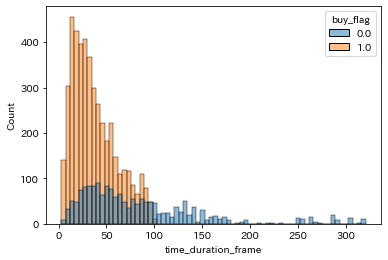

In [ ]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

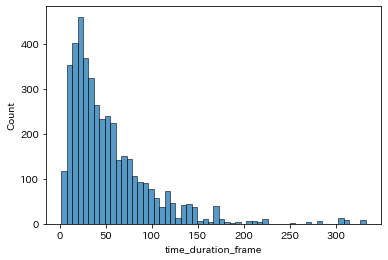

In [ ]:
sns.histplot(data=df_test, x="time_duration_frame")

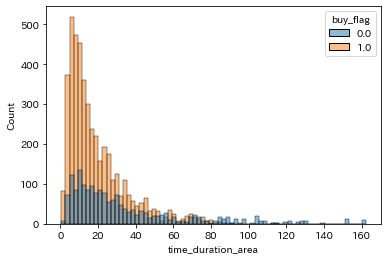

In [ ]:
sns.histplot(data=df_train, x="time_duration_area",hue="buy_flag")

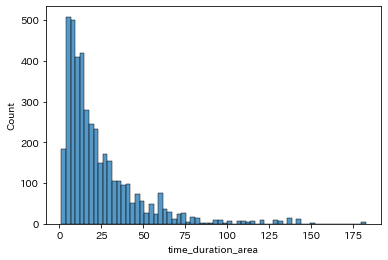

In [ ]:
sns.histplot(data=df_test, x="time_duration_area")

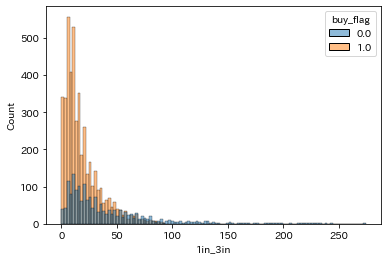

In [ ]:
sns.histplot(data=df_train, x="1in_3in",hue="buy_flag")

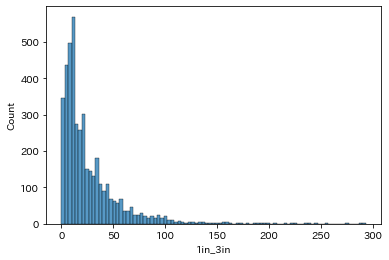

In [ ]:
sns.histplot(data=df_test, x="1in_3in")

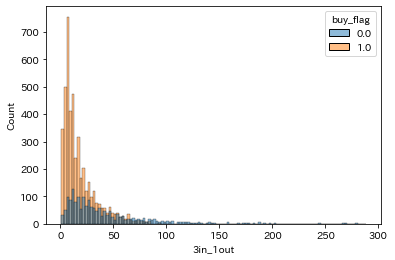

In [ ]:
sns.histplot(data=df_train, x="3in_1out",hue="buy_flag")

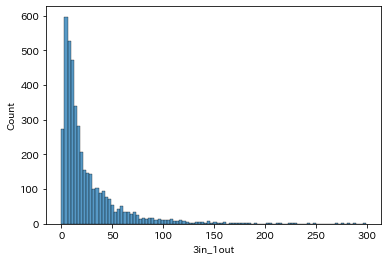

In [ ]:
sns.histplot(data=df_test, x="3in_1out")

In [ ]:
df_train.buy_flag.value_counts()

1.0    4571
0.0    1745
Name: buy_flag, dtype: int64

## オーバーサンプリング

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,6.2,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,6.2,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.6,7.8,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,7.8,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.2,14.0,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6311,20201101-120054,6,man,30's,Young,うるうるグリーンティー525ml,525,エターナル,1.0,13,15,28.4,11.2,0.0,21,38
6312,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,13,14,28.4,11.2,0.0,21,38
6313,20201101-120054,6,man,30's,Young,新緑の丘525ml,525,フューチャー,1.0,14,14,28.4,11.2,1.0,21,38
6314,20201101-120055,6,woman,30's,Young,ジャパンスプラッシュ500ml,500,クオリティー,5.0,6,7,14.0,13.0,0.0,21,39


In [ ]:
smote = BorderlineSMOTE(random_state = CONFIG.seed)
#sample_cols=["1in_3in", "3in_1out","time_duration_frame","time_duration_area","in_time_hour","in_time_min"]
sample_cols=["time_duration_frame","time_duration_area"]

#対象カラムのオーバーサンプリング
X, y = smote.fit_resample(df_train[sample_cols], df_train['buy_flag'])
df_oversample = pd.DataFrame(X, columns = sample_cols)
df_oversample["buy_flag"]=y
add_samples=df_oversample.iloc[list(df_train.index)[-1]+1:]

#buy_flag=0のrow複製
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
#オーバサンプリングした数値の上書き
add_nums = len(df_oversample)-len(df_train) 
sample_list = list(df_train[df_train.buy_flag==0].index)
over_items =random.choices(sample_list,k=add_nums)
add_df = df_train.loc[over_items]

In [ ]:
for i in sample_cols:
  add_df[i]=add_samples[i].values

In [ ]:
add_df

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
4393,20201031-020242,5,man,60's,Senior,燃えろイナヅマ600ml,600,エターナル,2.0,20,81,24.683086,17.947777,0.0,12,37
4821,20201031-060101,5,woman,50's,Middle,ワイルドティ525ml,525,イッツ園,1.0,15,28,53.600000,5.800000,0.0,17,26
2259,20201028-060107,2,woman,0's,Child,はじけろオレンジ500ml,500,フューチャー,3.0,90,5,77.879222,7.121426,0.0,18,42
2530,20201029-010128,3,woman,20's,Young,ボディベター650ml,650,イッツ園,1.0,22,11,89.750913,18.033498,0.0,10,0
3868,20201030-060025,4,woman,40's,Middle,こだわりコーヒー無糖500ml,500,フューチャー,1.0,139,126,81.200000,40.000000,0.0,18,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4511,20201031-030184,5,woman,20's,Young,日本の伝統525ml,525,クオリティー,1.0,3,13,37.000660,6.804621,0.0,14,28
3797,20201030-050154,4,woman,30's,Young,黒の息吹500ml,500,モーリーフラフト,2.0,50,77,32.324523,17.962261,0.0,17,21
2036,20201028-040057,2,woman,50's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,3.0,45,43,35.750543,24.851628,0.0,15,40
2925,20201029-050068,3,man,50's,Middle,しゅわしゅわプルーン500ml,500,クオリティー,1.0,2,22,11.285994,10.600000,0.0,17,5


In [ ]:
df_train = pd.concat([df_train,add_df],axis=0).reset_index(drop=True)

In [ ]:
df_train.buy_flag.value_counts()

0.0    4571
1.0    4571
Name: buy_flag, dtype: int64

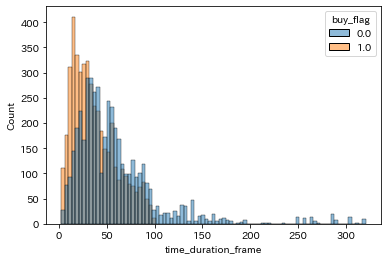

In [ ]:
sns.histplot(data=df_train, x="time_duration_frame",hue="buy_flag")

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-030184,5,woman,20's,Young,日本の伝統525ml,525,クオリティー,1.0,3,13,37.000660,6.804621,0.0,14,28
9138,20201030-050154,4,woman,30's,Young,黒の息吹500ml,500,モーリーフラフト,2.0,50,77,32.324523,17.962261,0.0,17,21
9139,20201028-040057,2,woman,50's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,3.0,45,43,35.750543,24.851628,0.0,15,40
9140,20201029-050068,3,man,50's,Middle,しゅわしゅわプルーン500ml,500,クオリティー,1.0,2,22,11.285994,10.600000,0.0,17,5


## Area外滞在時間/Area滞在時間率

In [ ]:
df_train["time_frameout"] = df_train["time_duration_frame"] - df_train["time_duration_area"]
df_test["time_frameout"] = df_test["time_duration_frame"] - df_test["time_duration_area"]

In [ ]:
df_train["time_area_rate"] = df_train["time_duration_area"] / df_train["time_duration_frame"]
df_test["time_area_rate"] = df_test["time_duration_area"] / df_test["time_duration_frame"]

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000
2,20201026-010002,0,man,50's,Middle,クリアブラウン525ml,525,クオリティー,1.0,6,6,13.600000,7.800000,1.0,8,2,5.800000,0.573529
3,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.600000,7.800000,1.0,8,2,5.800000,0.573529
4,20201026-010003,0,man,50's,Middle,桃の世界410ml,410,フューチャー,1.0,2,11,14.200000,14.000000,1.0,8,2,0.200000,0.985915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-030184,5,woman,20's,Young,日本の伝統525ml,525,クオリティー,1.0,3,13,37.000660,6.804621,0.0,14,28,30.196039,0.183905
9138,20201030-050154,4,woman,30's,Young,黒の息吹500ml,500,モーリーフラフト,2.0,50,77,32.324523,17.962261,0.0,17,21,14.362261,0.555685
9139,20201028-040057,2,woman,50's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,3.0,45,43,35.750543,24.851628,0.0,15,40,10.898915,0.695140
9140,20201029-050068,3,man,50's,Middle,しゅわしゅわプルーン500ml,500,クオリティー,1.0,2,22,11.285994,10.600000,0.0,17,5,0.685994,0.939217


## ターゲットエンコーディング（購入率）

In [ ]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [ ]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time_hour']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,buy_flag,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.541251,0.483219,0.562390,0.574824,0.789668,0.565473,0.645357,0.528696,0.570720
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.200000,6.200000,1.0,8,1,0.000000,1.000000,0.541251,0.483219,0.562390,0.574824,0.789668,0.565473,0.645357,0.528696,0.570720
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.400000,8.200000,1.0,8,2,11.200000,0.422680,0.459522,0.483219,0.562390,0.574824,0.789668,0.565473,0.645357,0.528696,0.570720
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.000000,7.800000,1.0,8,43,35.200000,0.181395,0.459522,0.483219,0.562390,0.574824,0.789668,0.565473,0.645357,0.528696,0.570720
4,20201026-010050,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,16,7,23.800000,12.200000,1.0,8,50,11.600000,0.512605,0.541251,0.519781,0.562390,0.574824,0.789668,0.565473,0.645357,0.528696,0.570720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,20201031-040037,5,woman,30's,Young,水玉ウォーター500ml,500,カルシウムウェイ,2.0,12,10,22.600000,4.200000,1.0,15,19,18.400000,0.185841,0.421885,0.483219,0.562390,0.574824,0.425000,0.516602,0.425000,0.452496,0.393199
9138,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,57.200000,5.600000,0.0,15,4,51.600000,0.097902,0.528090,0.519781,0.589963,0.551527,0.062500,0.143552,0.078431,0.452496,0.393199
9139,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,11,45,57.200000,5.600000,1.0,15,4,51.600000,0.097902,0.528090,0.519781,0.589963,0.551527,0.062500,0.143552,0.078431,0.452496,0.393199
9140,20201101-070012,6,man,50's,Middle,キッズアップル470ml,470,オールフロント,2.0,9,48,92.094588,55.052706,0.0,15,4,37.041882,0.597784,0.528090,0.519781,0.589963,0.551527,0.062500,0.143552,0.078431,0.452496,0.393199


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration_frame,time_duration_area,in_time_hour,in_time_min,time_frameout,time_area_rate,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time_hour
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,11.0,19.8,7.2,8,7,12.6,0.363636,0.541251,0.519781,0.518106,0.551527,0.785124,0.565473,0.645357,0.528696,0.570720
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,9.0,19.8,7.2,8,7,12.6,0.363636,0.541251,0.519781,0.518106,0.551527,0.785124,0.565473,0.645357,0.528696,0.570720
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,4.0,14.4,5.2,8,1,9.2,0.361111,0.542883,0.519781,0.518106,0.551527,0.785124,0.565473,0.645357,0.528696,0.570720
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8.0,10.0,18.4,7.2,8,7,11.2,0.391304,0.515200,0.519781,0.518106,0.551527,0.785124,0.565473,0.645357,0.528696,0.570720
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10.0,8.0,18.4,7.2,8,7,11.2,0.391304,0.515200,0.519781,0.518106,0.551527,0.785124,0.565473,0.645357,0.528696,0.570720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,20201101-050032,6,woman,40's,Middle,黒の息吹500ml,500,モーリーフラフト,2.0,51.0,13.0,64.8,37.8,13,13,27.0,0.583333,0.528090,0.483219,0.518106,0.551527,0.438017,0.516602,0.316602,0.452496,0.564489
4290,20201101-050032,6,woman,40's,Middle,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,44.0,20.0,64.8,37.8,13,13,27.0,0.583333,0.528090,0.483219,0.518106,0.551527,0.210145,0.287805,0.316602,0.452496,0.564489
4291,20201029-030110,3,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,36.0,13.0,50.0,35.8,13,59,14.2,0.716000,0.542883,0.483219,0.562390,0.574824,0.210145,0.287805,0.316602,0.452496,0.564489
4292,20201031-030018,5,woman,30's,Young,ミルクマシマシラテ450ml,450,モーリーフラフト,2.0,14.0,11.0,25.8,10.8,13,5,15.0,0.418605,0.421885,0.483219,0.562390,0.574824,0.210145,0.287805,0.316602,0.452496,0.564489


## カテゴリーのエンコーディング

In [ ]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [ ]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time_hour',
            'in_time_min',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [ ]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [ ]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time_hour','in_time_min','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

# モデル作成　(LightGBM)

In [ ]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)

        #print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        #pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

In [ ]:
def fit_lgbm_param_optuna(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = roc_auc_score

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 

        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred
        models.append(clf)

        score=metric_func(y_valid, pred)

    return score

def objective_lgbm(trial):

    fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

    train_x=df_train_encoded.drop(columns=["customer_id"])
    train_x = train_x.iloc[:,:-1]
    train_y = df_train_encoded["buy_flag"]
    
    fold = KFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    cv = list(fold.split(train_x, train_y))

    optuna_paramas_lgb = {
        'num_leaves': trial.suggest_int('num_leaves', 32, 512),
        'boosting_type': 'gbdt',
        'max_bin': trial.suggest_int('max_bin', 700, 900),
        'objective': 'huber',
        'metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate',0.0155,0.05),
        'random_state' : 71,
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        'early_stopping_rounds': 10}


    score = fit_lgbm_param_optuna(train_x.values,  train_y, cv=cv, params=optuna_paramas_lgb)
    print("Score:"+str(score))
    
    return score

study = optuna.create_study(direction="minimize", study_name='lgb_train')
study.optimize(objective_lgbm, n_trials=10)

[I 2021-09-22 06:40:01,970] A new study created in memory with name: lgb_train
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.356767
[100]	valid_0's l1: 0.312927
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.312927
fit fold=1 0.281[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.349712


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.310331
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.310331
fit fold=2 0.269[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.355467


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.314567
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.314567
fit fold=3 0.278[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.344169


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.298521
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.298521
fit fold=4 0.275[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.348869


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.305005
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.305005
fit fold=5 0.269[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.349746


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.307874
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.307874
fit fold=6 0.267[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.353349


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.310659
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.310659
fit fold=7 0.273[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.359773


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.319491
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.319491
fit fold=8 0.278[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.35291


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[100]	valid_0's l1: 0.310459
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.310459
fit fold=9 0.266[s]
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.357553


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

[I 2021-09-22 06:40:04,826] Trial 0 finished with value: 0.8844265439202148 and parameters: {'num_leaves': 49, 'max_bin': 758, 'learning_rate': 0.04340036066889474, 'max_depth': 5, 'min_child_weight': 15, 'feature_fraction': 0.4158033742754594, 'bagging_fraction': 0.6463673564516992, 'bagging_freq': 6, 'min_child_samples': 11, 'lambda_l1': 0.15921692402642101, 'lambda_l2': 0.011652849527974785}. Best is trial 0 with value: 0.8844265439202148.


[100]	valid_0's l1: 0.316244
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.316244
fit fold=10 0.266[s]
Score:0.8844265439202148
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.399336
[100]	valid_0's l1: 0.349128
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.349128
fit fold=1 0.362[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.396263
[100]	valid_0's l1: 0.34341
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.34341
fit fold=2 0.336[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.398972
[100]	valid_0's l1: 0.34933
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.34933
fit fold=3 0.335[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.391716
[100]	valid_0's l1: 0.338553
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.338553
fit fold=4 0.356[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.393924
[100]	valid_0's l1: 0.342412
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.342412
fit fold=5 0.339[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.395843
[100]	valid_0's l1: 0.345263
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.345263
fit fold=6 0.360[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.401374
[100]	valid_0's l1: 0.348819
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.348819
fit fold=7 0.345[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.407483
[100]	valid_0's l1: 0.361418
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.361418
fit fold=8 0.353[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.399103
[100]	valid_0's l1: 0.348585
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.348585
fit fold=9 0.348[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.403335


[I 2021-09-22 06:40:08,416] Trial 1 finished with value: 0.8611958189489836 and parameters: {'num_leaves': 507, 'max_bin': 857, 'learning_rate': 0.0188723524087762, 'max_depth': 4, 'min_child_weight': 9, 'feature_fraction': 0.8671166482198466, 'bagging_fraction': 0.5331107535755477, 'bagging_freq': 2, 'min_child_samples': 9, 'lambda_l1': 0.018792680122168146, 'lambda_l2': 0.006716322735432155}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.354216
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.354216
fit fold=10 0.339[s]
Score:0.8611958189489836
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.324421
[100]	valid_0's l1: 0.276704
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.276704
fit fold=1 0.518[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.321711
[100]	valid_0's l1: 0.274281
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.274281
fit fold=2 0.516[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.325285
[100]	valid_0's l1: 0.276945
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.276945
fit fold=3 0.533[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.314989
[100]	valid_0's l1: 0.265312
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.265312
fit fold=4 0.533[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.316585
[100]	valid_0's l1: 0.270931
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.270931
fit fold=5 0.527[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.321849
[100]	valid_0's l1: 0.276213
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.276213
fit fold=6 0.529[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.322402
[100]	valid_0's l1: 0.276128
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.276128
fit fold=7 0.528[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.333573
[100]	valid_0's l1: 0.28953
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.28953
fit fold=8 0.540[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.321742
[100]	valid_0's l1: 0.271798
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.271798
fit fold=9 0.528[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.329134


[I 2021-09-22 06:40:13,876] Trial 2 finished with value: 0.9081415420023015 and parameters: {'num_leaves': 240, 'max_bin': 768, 'learning_rate': 0.04187746009387708, 'max_depth': 7, 'min_child_weight': 2, 'feature_fraction': 0.5177254434501664, 'bagging_fraction': 0.6957180285842899, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 1.1537726370076763e-06, 'lambda_l2': 1.0214591902711944e-08}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.279977
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.279977
fit fold=10 0.551[s]
Score:0.9081415420023015
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.285996
[100]	valid_0's l1: 0.236685
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.236685
fit fold=1 1.111[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.286456
[100]	valid_0's l1: 0.237694
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.237694
fit fold=2 1.097[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.294432
[100]	valid_0's l1: 0.244948
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.244948
fit fold=3 1.173[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.277045
[100]	valid_0's l1: 0.225962
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.225962
fit fold=4 1.173[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.279807
[100]	valid_0's l1: 0.233832
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.233832
fit fold=5 1.179[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.280303
[100]	valid_0's l1: 0.232149
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.232149
fit fold=6 1.156[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.282939
[100]	valid_0's l1: 0.233021
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.233021
fit fold=7 1.172[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.295719
[100]	valid_0's l1: 0.250324
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.250324
fit fold=8 1.168[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.280733
[100]	valid_0's l1: 0.233871
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.233871
fit fold=9 1.125[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.291146


[I 2021-09-22 06:40:25,620] Trial 3 finished with value: 0.9336066359800537 and parameters: {'num_leaves': 304, 'max_bin': 798, 'learning_rate': 0.046888662433484836, 'max_depth': 12, 'min_child_weight': 15, 'feature_fraction': 0.5109888601385782, 'bagging_fraction': 0.698403208209782, 'bagging_freq': 1, 'min_child_samples': 11, 'lambda_l1': 0.02149220246963663, 'lambda_l2': 4.979082036373577e-05}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.244579
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.244579
fit fold=10 1.176[s]
Score:0.9336066359800537


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.399085
[100]	valid_0's l1: 0.345528
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.345528
fit fold=1 0.373[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.397702
[100]	valid_0's l1: 0.345114
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.345114
fit fold=2 0.383[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.399874
[100]	valid_0's l1: 0.346907
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.346907
fit fold=3 0.374[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.394104
[100]	valid_0's l1: 0.336448
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.336448
fit fold=4 0.374[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.394839
[100]	valid_0's l1: 0.338781
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.338781
fit fold=5 0.371[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.39649
[100]	valid_0's l1: 0.34255
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.34255
fit fold=6 0.375[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.400316
[100]	valid_0's l1: 0.347243
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.347243
fit fold=7 0.392[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.40459
[100]	valid_0's l1: 0.355285
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.355285
fit fold=8 0.385[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.399049
[100]	valid_0's l1: 0.34536
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.34536
fit fold=9 0.384[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

[I 2021-09-22 06:40:29,611] Trial 4 finished with value: 0.8754507096279247 and parameters: {'num_leaves': 130, 'max_bin': 741, 'learning_rate': 0.018205746395662113, 'max_depth': 8, 'min_child_weight': 1, 'feature_fraction': 0.581602684963308, 'bagging_fraction': 0.5196417618247204, 'bagging_freq': 4, 'min_child_samples': 69, 'lambda_l1': 0.2758524294453859, 'lambda_l2': 0.6128295754677926}. Best is trial 1 with value: 0.8611958189489836.


[50]	valid_0's l1: 0.40298
[100]	valid_0's l1: 0.351358
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.351358
fit fold=10 0.422[s]
Score:0.8754507096279247


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.32712
[100]	valid_0's l1: 0.292832
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.292832
fit fold=1 0.382[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.321664
[100]	valid_0's l1: 0.288418
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.288418
fit fold=2 0.397[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.329871
[100]	valid_0's l1: 0.29846
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.29846
fit fold=3 0.386[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.314965
[100]	valid_0's l1: 0.28178
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.28178
fit fold=4 0.378[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.317139
[100]	valid_0's l1: 0.284701
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.284701
fit fold=5 0.395[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.321066
[100]	valid_0's l1: 0.28499
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.28499
fit fold=6 0.379[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.324994
[100]	valid_0's l1: 0.290339
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.290339
fit fold=7 0.393[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.340936
[100]	valid_0's l1: 0.310706
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.310706
fit fold=8 0.386[s]


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.323079
[100]	valid_0's l1: 0.284825
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.284825
fit fold=9 0.401[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

[I 2021-09-22 06:40:33,626] Trial 5 finished with value: 0.8914700805523589 and parameters: {'num_leaves': 431, 'max_bin': 722, 'learning_rate': 0.04802780715945774, 'max_depth': 5, 'min_child_weight': 7, 'feature_fraction': 0.6721212144367186, 'bagging_fraction': 0.9237604589726173, 'bagging_freq': 3, 'min_child_samples': 57, 'lambda_l1': 0.0007018135905053549, 'lambda_l2': 7.331506171260762e-05}. Best is trial 1 with value: 0.8611958189489836.


[50]	valid_0's l1: 0.330559
[100]	valid_0's l1: 0.296387
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.296387
fit fold=10 0.386[s]
Score:0.8914700805523589


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds.
[50]	valid_0's l1: 0.366984
[100]	valid_0's l1: 0.304715
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.304715
fit fold=1 0.799[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.366746
[100]	valid_0's l1: 0.306394
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.306394
fit fold=2 0.784[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.370914
[100]	valid_0's l1: 0.309994
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.309994
fit fold=3 0.767[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.361132
[100]	valid_0's l1: 0.29601
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.29601
fit fold=4 0.777[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.362569
[100]	valid_0's l1: 0.299317
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.299317
fit fold=5 0.766[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.36527
[100]	valid_0's l1: 0.303167
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.303167
fit fold=6 0.771[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.366145
[100]	valid_0's l1: 0.304586
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.304586
fit fold=7 0.783[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.374807
[100]	valid_0's l1: 0.317798
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.317798
fit fold=8 0.782[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.363564
[100]	valid_0's l1: 0.301743
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.301743
fit fold=9 0.771[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.372527


[I 2021-09-22 06:40:41,593] Trial 6 finished with value: 0.903783084004603 and parameters: {'num_leaves': 156, 'max_bin': 798, 'learning_rate': 0.022609669639739427, 'max_depth': 13, 'min_child_weight': 7, 'feature_fraction': 0.524546884817804, 'bagging_fraction': 0.8862127948135072, 'bagging_freq': 6, 'min_child_samples': 48, 'lambda_l1': 3.6510278990941387e-07, 'lambda_l2': 9.211782574069016e-08}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.315134
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.315134
fit fold=10 0.772[s]
Score:0.903783084004603
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.29466
[100]	valid_0's l1: 0.252634
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.252634
fit fold=1 0.641[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.293434
[100]	valid_0's l1: 0.259336
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.259336
fit fold=2 0.651[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.29591
[100]	valid_0's l1: 0.260612
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.260612
fit fold=3 0.655[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.286951
[100]	valid_0's l1: 0.246301
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.246301
fit fold=4 0.630[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.290543
[100]	valid_0's l1: 0.250208
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.250208
fit fold=5 0.654[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.293531
[100]	valid_0's l1: 0.253023
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.253023
fit fold=6 0.646[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.299915
[100]	valid_0's l1: 0.255685
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.255685
fit fold=7 0.638[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.307759
[100]	valid_0's l1: 0.270248
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.270248
fit fold=8 0.638[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.293207
[100]	valid_0's l1: 0.250988
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.250988
fit fold=9 0.636[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.303525


[I 2021-09-22 06:40:48,201] Trial 7 finished with value: 0.9118670886075949 and parameters: {'num_leaves': 193, 'max_bin': 786, 'learning_rate': 0.04972365557168193, 'max_depth': 13, 'min_child_weight': 6, 'feature_fraction': 0.6477012920681722, 'bagging_fraction': 0.5224329721961454, 'bagging_freq': 3, 'min_child_samples': 40, 'lambda_l1': 0.011684858577125746, 'lambda_l2': 7.61079355009431e-05}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.26847
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.26847
fit fold=10 0.634[s]
Score:0.9118670886075949
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.312615
[100]	valid_0's l1: 0.270546
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.270546
fit fold=1 0.597[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.309421
[100]	valid_0's l1: 0.270374
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.270374
fit fold=2 0.592[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.31542
[100]	valid_0's l1: 0.275496
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.275496
fit fold=3 0.592[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.304764
[100]	valid_0's l1: 0.262022
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.262022
fit fold=4 0.580[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.306223
[100]	valid_0's l1: 0.265108
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.265108
fit fold=5 0.589[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.313005
[100]	valid_0's l1: 0.269856
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.269856
fit fold=6 0.606[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.31343
[100]	valid_0's l1: 0.270564
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.270564
fit fold=7 0.589[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.325292
[100]	valid_0's l1: 0.287269
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.287269
fit fold=8 0.609[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.312072
[100]	valid_0's l1: 0.267403
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.267403
fit fold=9 0.588[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.318906


[I 2021-09-22 06:40:54,329] Trial 8 finished with value: 0.9041043344840812 and parameters: {'num_leaves': 427, 'max_bin': 817, 'learning_rate': 0.041759716986382894, 'max_depth': 16, 'min_child_weight': 10, 'feature_fraction': 0.8507991203763319, 'bagging_fraction': 0.564042680937777, 'bagging_freq': 3, 'min_child_samples': 71, 'lambda_l1': 0.013719811541175728, 'lambda_l2': 0.0018028458646404683}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.278598
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.278598
fit fold=10 0.611[s]
Score:0.9041043344840812
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.369887
[100]	valid_0's l1: 0.308904
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.308904
fit fold=1 0.655[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.368693
[100]	valid_0's l1: 0.309163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.309163
fit fold=2 0.646[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.372104
[100]	valid_0's l1: 0.31371
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.31371
fit fold=3 0.682[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.362138
[100]	valid_0's l1: 0.297815
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.297815
fit fold=4 0.674[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.363889
[100]	valid_0's l1: 0.302303
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.302303
fit fold=5 0.676[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.367449
[100]	valid_0's l1: 0.304836
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.304836
fit fold=6 0.671[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.368735
[100]	valid_0's l1: 0.308094
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.308094
fit fold=7 0.667[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.377255
[100]	valid_0's l1: 0.323381
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.323381
fit fold=8 0.676[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.368361
[100]	valid_0's l1: 0.308358
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.308358
fit fold=9 0.676[s]
Training until validation scores don't improve for 10 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[50]	valid_0's l1: 0.374327


[I 2021-09-22 06:41:01,195] Trial 9 finished with value: 0.8978998849252013 and parameters: {'num_leaves': 470, 'max_bin': 799, 'learning_rate': 0.022517654025477327, 'max_depth': 8, 'min_child_weight': 15, 'feature_fraction': 0.6020076854929096, 'bagging_fraction': 0.8619593510430461, 'bagging_freq': 6, 'min_child_samples': 45, 'lambda_l1': 0.00339317877298947, 'lambda_l2': 7.574303749615688e-05}. Best is trial 1 with value: 0.8611958189489836.


[100]	valid_0's l1: 0.315804
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.315804
fit fold=10 0.680[s]
Score:0.8978998849252013


In [ ]:
study.best_params

{'bagging_fraction': 0.5331107535755477,
 'bagging_freq': 2,
 'feature_fraction': 0.8671166482198466,
 'lambda_l1': 0.018792680122168146,
 'lambda_l2': 0.006716322735432155,
 'learning_rate': 0.0188723524087762,
 'max_bin': 857,
 'max_depth': 4,
 'min_child_samples': 9,
 'min_child_weight': 9,
 'num_leaves': 507}

## 学習

In [ ]:
fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

train_x=df_train_encoded.drop(columns=["customer_id"])
train_x = train_x.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_xgb(train_x.values, train_y, cv, params=study.best_params)

fit fold=1 1.193[s]
AUC 0 Score: 0.8933
fit fold=2 1.207[s]
AUC 1 Score: 0.8683
fit fold=3 1.163[s]
AUC 2 Score: 0.8806
fit fold=4 1.162[s]
AUC 3 Score: 0.8802
fit fold=5 1.173[s]
AUC 4 Score: 0.8799
fit fold=6 1.163[s]
AUC 5 Score: 0.8600
fit fold=7 1.189[s]
AUC 6 Score: 0.8454
fit fold=8 1.154[s]
AUC 7 Score: 0.8614
fit fold=9 1.146[s]
AUC 8 Score: 0.8764
fit fold=10 1.161[s]
AUC 9 Score: 0.8876
FINISHED | AUC Score: 0.8731


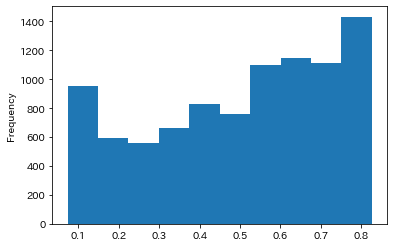

In [ ]:
oof["pred_prob"].plot(kind="hist")

In [ ]:
df_train_encoded[["customer_id"]]

,customer_id
0,20201026-010001
1,20201026-010001
2,20201027-010002
3,20201027-010049
4,20201026-010050
...,...
9137,20201031-040037
9138,20201101-070012
9139,20201101-070012
9140,20201101-070012


In [ ]:
train_pred_1=pd.concat([oof[["pred_prob","y"]],df_train_encoded[["customer_id"]]],axis=1).set_index("customer_id")

In [ ]:
a=df_train_org[df_train_org.event_type!=3].customer_id.unique()
b=df_train_org[df_train_org.event_type==3].customer_id.unique()
others_list=list(set(list(a)) ^ set(list(b)) )

train_pred_0 = pd.DataFrame()
train_pred_0["customer_id"] = others_list
train_pred_0["pred_prob"] = 0
train_pred_0["y"] = 0
train_pred_0=train_pred_0.set_index("customer_id")
train_pred=pd.concat([train_pred_1,train_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [ ]:
score = roc_auc_score(train_pred["y"], train_pred["pred_prob"]) 
print('Train | AUC Score: {:.4f}'.format(score))

Train | AUC Score: 0.9280


## 学習結果

In [ ]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

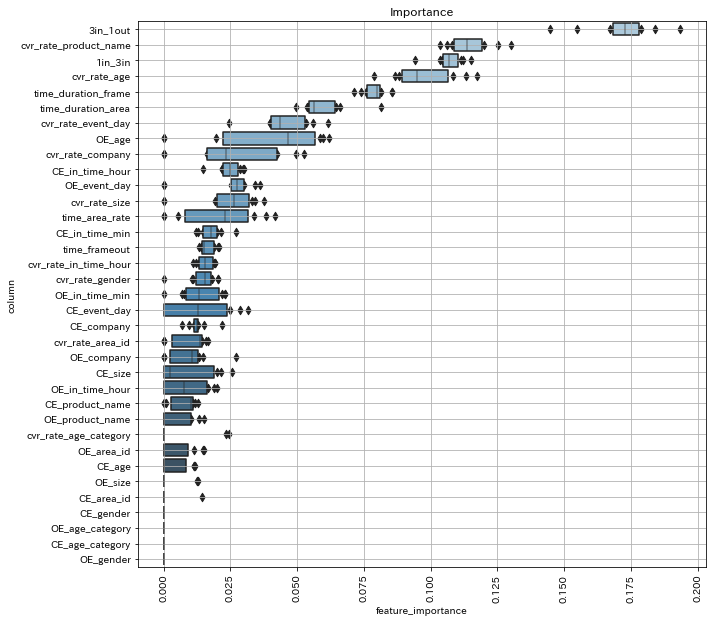

In [ ]:
fig, ax = visualize_importance(models, train_x)

In [ ]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

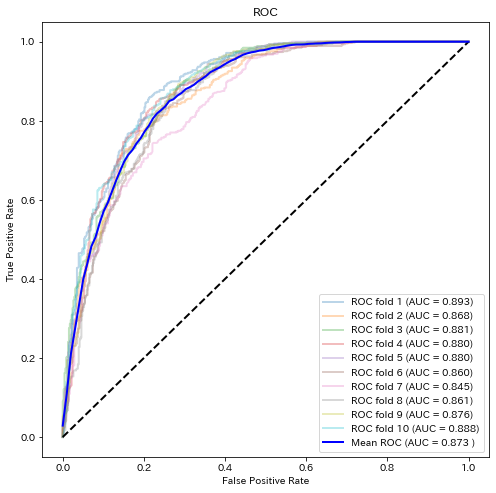

In [ ]:
visulalize_roc(oof,CONFIG.fold)

In [ ]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

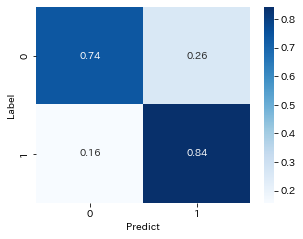

In [ ]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [ ]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]
#pred = np.where(pred < 0.5, 0, 1)

In [ ]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [ ]:
submission_pred = submission_pred.groupby("customer_id").max()

In [ ]:
submission_pred

,buy_proba
customer_id,
20201026-010006,0.810116
20201026-010008,0.796538
20201026-010011,0.731266
20201026-010012,0.812294
20201026-010018,0.460627
...,...
20201101-120031,0.812123
20201101-120033,0.641688
20201101-120051,0.790167


In [ ]:
#submission_pred=submission_pred.groupby("customer_id").mean().reset_index()
#pred = np.where( submission_pred["buy_proba"].values<0.5, 0, 1)
#submission_pred["buy_proba"]=pred
#submission_pred=submission_pred.set_index("customer_id")

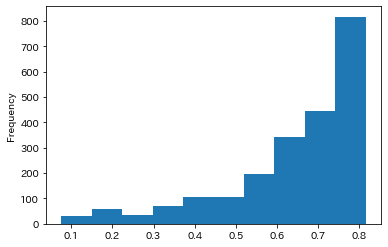

In [ ]:
submission_pred["buy_proba"].plot(kind="hist")

In [ ]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [ ]:
submission_pred_0

,buy_proba
customer_id,
20201101-050023,0
20201029-020035,0
20201031-030041,0
20201030-060129,0
20201031-030171,0
...,...
20201026-040070,0
20201027-020034,0
20201029-020124,0


In [ ]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [ ]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.810116
1,20201026-010008,0.796538
2,20201026-010011,0.731266
3,20201026-010012,0.812294
4,20201026-010018,0.460627
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.790167
4528,20201101-120052,0.733170


In [ ]:
submission_pred_all.buy_proba.value_counts()

0.000000    2326
0.816709       8
0.806265       7
0.813157       6
0.814321       5
            ... 
0.630244       1
0.786497       1
0.653852       1
0.518583       1
0.765348       1
Name: buy_proba, Length: 2048, dtype: int64

In [ ]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)